<a href="https://colab.research.google.com/github/sharmaudit2109/Toxic_Comment_Classification/blob/main/Toxicity_Check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# reading the training data file
comments_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
print(comments_df.head())
comments_df.to_csv('train.csv', index=False) # to remove indexing in order to alter the file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


# Exploratory Data Analysis



In [ ]:
print(comments_df.info)

<bound method DataFrame.info of                       id                                       comment_text  \
0       0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1       000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2       000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3       0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4       0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  seve

In [ ]:
print(comments_df.describe())

               toxic   severe_toxic        obscene         threat  \
count  159571.000000  159571.000000  159571.000000  159571.000000   
mean        0.095844       0.009996       0.052948       0.002996   
std         0.294379       0.099477       0.223931       0.054650   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              insult  identity_hate  
count  159571.000000  159571.000000  
mean        0.049364       0.008805  
std         0.216627       0.093420  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000  


In [ ]:
print(comments_df.nunique())

id               159571
comment_text     159571
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
dtype: int64


In [ ]:
print(comments_df.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


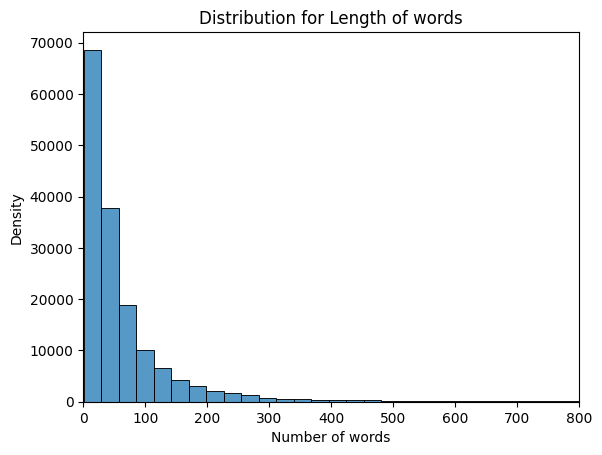

In [ ]:
# Plot for representing the distribution for length of words
comment_length = comments_df['comment_text'].str.split().apply(len)
sns.histplot(comment_length, bins=50)
plt.title("Distribution for Length of words")
plt.xlabel("Number of words")
plt.ylabel("Density")
plt.xlim(0, 800)
plt.show()

In [ ]:
rowSums = comments_df.iloc[:, 2:].sum(axis=1)
clean_comments_count = (rowSums == 0).sum(axis=0)
print("Total number of comments = ", len(comments_df))
print("Number of clean comments = ", clean_comments_count)
print("Number of comments with labels =", (len(comments_df) - clean_comments_count))

Total number of comments =  159571
Number of clean comments =  143346
Number of comments with labels = 16225


In [ ]:
categories = list(comments_df.columns.values)
categories = categories[2:]
print(categories)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [ ]:
counts = []
for category in categories:
  counts.append((category, comments_df[category].sum()))
counts.append(('clean', clean_comments_count))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
print(df_stats)

        category  number of comments
0          toxic               15294
1   severe_toxic                1595
2        obscene                8449
3         threat                 478
4         insult                7877
5  identity_hate                1405
6          clean              143346


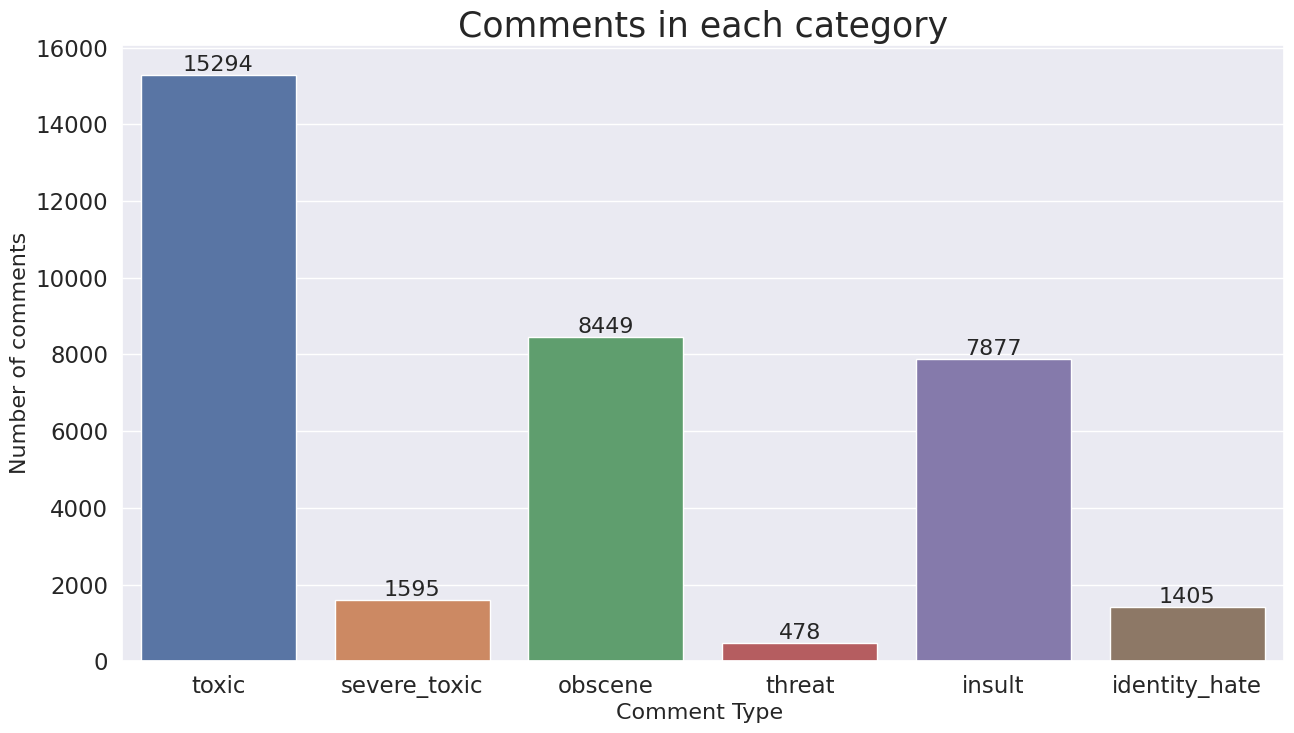

In [ ]:
# Plot showing comments under each category
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 8))
fig = sns.barplot(x=categories, y=comments_df.iloc[:, 2:].sum().values)
plt.title("Comments in each category", fontsize=25)
plt.ylabel('Number of comments', fontsize=16)
plt.xlabel('Comment Type ', fontsize=16)
# adding counts for the labels
rects = fig.patches
labels = comments_df.iloc[:, 2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    fig.text(rect.get_x() + rect.get_width() / 2, height + 4, label, ha='center', va='bottom', fontsize=16)
plt.show()

In [ ]:
rowSums = comments_df.iloc[:, 2:].sum(axis=1)
multiLabel_count = rowSums.value_counts()
multiLabel_count = multiLabel_count.iloc[1:].sort_index()

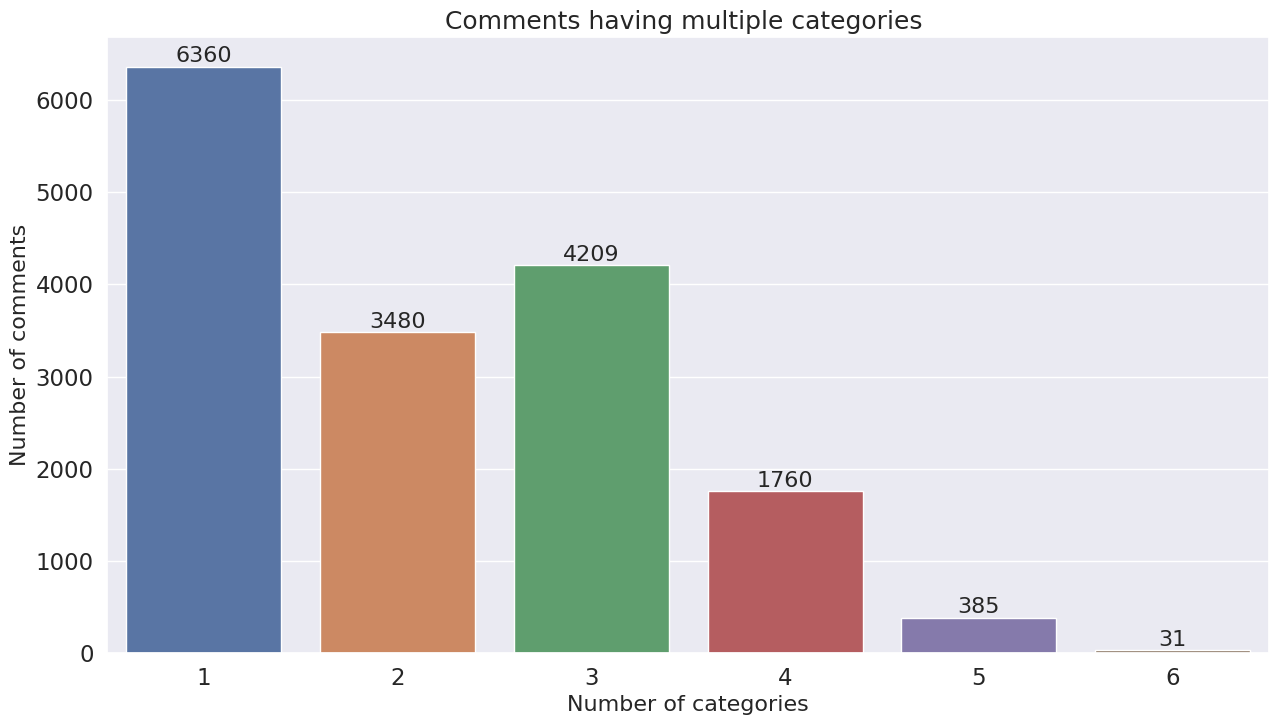

In [ ]:
# Plot showing comments under multiple categories
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 8))
fig = sns.barplot(x=multiLabel_count.index, y=multiLabel_count.values)
plt.title("Comments having multiple categories ")
plt.ylabel('Number of comments', fontsize=16)
plt.xlabel('Number of categories', fontsize=16)
# adding counts for the labels
rects = fig.patches
labels = multiLabel_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    fig.text(rect.get_x() + rect.get_width() / 2, height + 4, label, ha='center', va='bottom', fontsize='16')
plt.show()

In [ ]:
correlation_val = comments_df.corr()
print(correlation_val)

                  toxic  severe_toxic   obscene    threat    insult  \
toxic          1.000000      0.308619  0.676515  0.157058  0.647518   
severe_toxic   0.308619      1.000000  0.403014  0.123601  0.375807   
obscene        0.676515      0.403014  1.000000  0.141179  0.741272   
threat         0.157058      0.123601  0.141179  1.000000  0.150022   
insult         0.647518      0.375807  0.741272  0.150022  1.000000   
identity_hate  0.266009      0.201600  0.286867  0.115128  0.337736   

               identity_hate  
toxic               0.266009  
severe_toxic        0.201600  
obscene             0.286867  
threat              0.115128  
insult              0.337736  
identity_hate       1.000000  


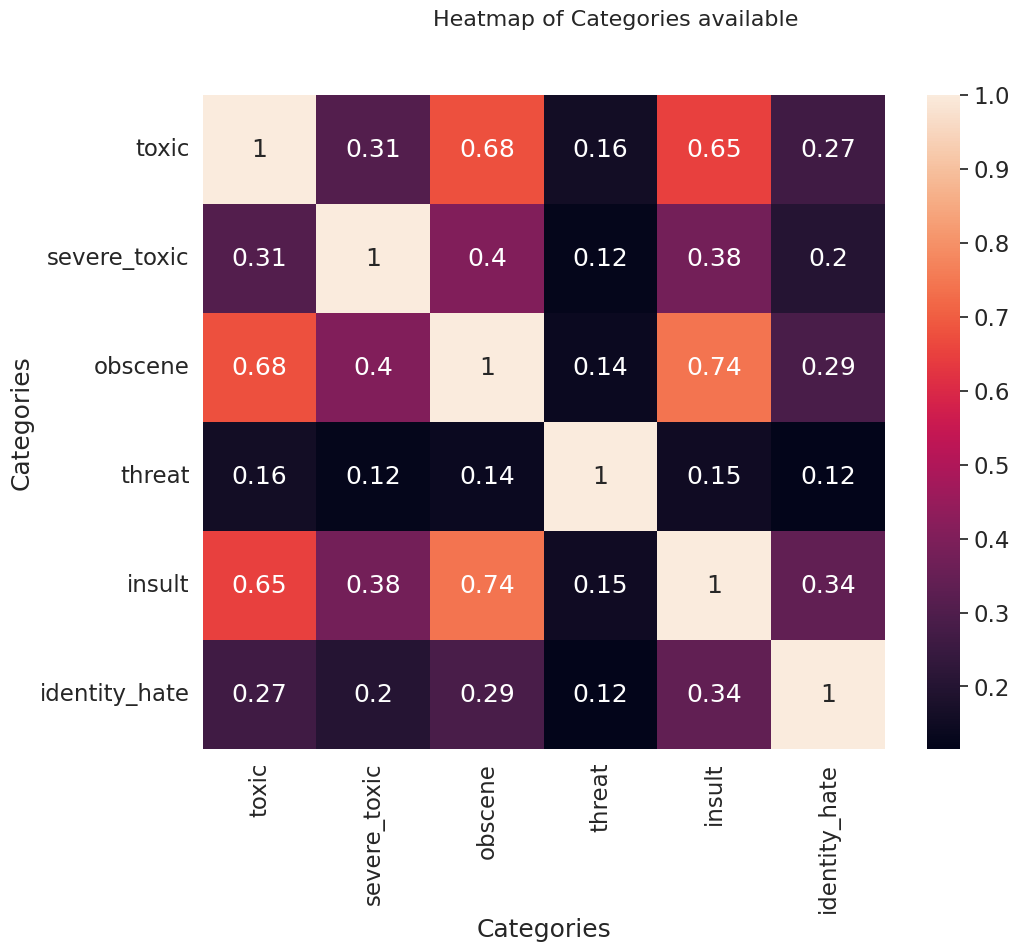

In [ ]:
# For better visualization, we will represent these values via Heatmap.
plt.figure(figsize=(11, 8.5))
sns.heatmap(comments_df.corr(), annot=True)
plt.suptitle('Heatmap of Categories available', size=16)
plt.xlabel("Categories")
plt.ylabel("Categories")
plt.show()

<Axes: >

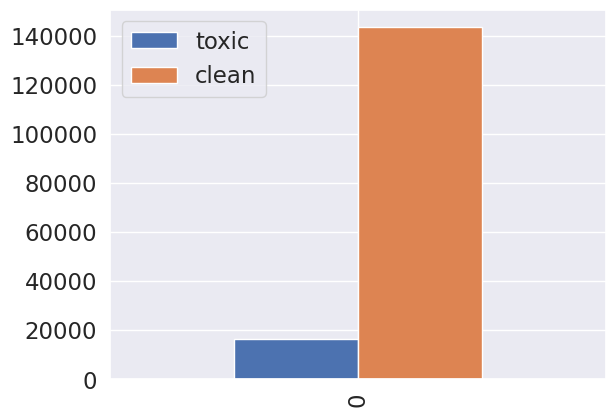

In [ ]:
# Plot showing Toxic comments vs Clean Comments count
toxic_comments = comments_df[comments_df[categories].sum(axis=1) > 0]
clean_comments = comments_df[comments_df[categories].sum(axis=1) == 0]
pd.DataFrame(dict(toxic=[len(toxic_comments)], clean=[len(clean_comments)])).plot(kind='bar')

# Data Cleaning

In [ ]:
# Remove irrelevant columns
print("Removing irrelevant columns...")
irrelevant_columns = ["id"]
comments_df = comments_df.drop(irrelevant_columns, axis=1)
print(comments_df.columns.values)

Removing irrelevant columns...
['comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate']


In [ ]:
# Remove duplicate rows
print("Removing duplicate rows...")
comments_df = comments_df.drop_duplicates()
print(comments_df.shape)

Removing duplicate rows...
(159571, 7)


In [ ]:
# Remove null values
print("Removing null values...")
comments_df = comments_df.dropna()
print(comments_df.shape)

Removing null values...
(159571, 7)


In [ ]:
# Remove URLs, usernames, and email addresses

print("Removing URLs, usernames, and email addresses...")
def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+|@\S+', '', text)
comments_df['comment_text'] = comments_df['comment_text'].apply(remove_urls)
print(comments_df.head)

Removing URLs, usernames, and email addresses...
<bound method NDFrame.head of                                              comment_text  toxic  \
0       Explanation\nWhy the edits made under my usern...      0   
1       D'aww! He matches this background colour I'm s...      0   
2       Hey man, I'm really not trying to edit war. It...      0   
3       "\nMore\nI can't make any real suggestions on ...      0   
4       You, sir, are my hero. Any chance you remember...      0   
...                                                   ...    ...   
159566  ":::::And for the second time of asking, when ...      0   
159567  You should be ashamed of yourself \n\nThat is ...      0   
159568  Spitzer \n\nUmm, theres no actual article for ...      0   
159569  And it looks like it was actually you who put ...      0   
159570  "\nAnd ... I really don't think you understand...      0   

        severe_toxic  obscene  threat  insult  identity_hate  
0                  0        0       0    

In [ ]:
# Remove HTML tags

print("Removing HTML tags...")
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)
comments_df['comment_text'] = comments_df['comment_text'].apply(remove_html_tags)
print(comments_df.head)

Removing HTML tags...
<bound method NDFrame.head of                                              comment_text  toxic  \
0       Explanation\nWhy the edits made under my usern...      0   
1       D'aww! He matches this background colour I'm s...      0   
2       Hey man, I'm really not trying to edit war. It...      0   
3       "\nMore\nI can't make any real suggestions on ...      0   
4       You, sir, are my hero. Any chance you remember...      0   
...                                                   ...    ...   
159566  ":::::And for the second time of asking, when ...      0   
159567  You should be ashamed of yourself \n\nThat is ...      0   
159568  Spitzer \n\nUmm, theres no actual article for ...      0   
159569  And it looks like it was actually you who put ...      0   
159570  "\nAnd ... I really don't think you understand...      0   

        severe_toxic  obscene  threat  insult  identity_hate  
0                  0        0       0       0              0  
1    

In [ ]:
# Remove punctuation

print("Removing punctuation...")
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
comments_df['comment_text'] = comments_df['comment_text'].apply(remove_punctuation)
print(comments_df.head)

Removing punctuation...
<bound method NDFrame.head of                                              comment_text  toxic  \
0       Explanation\nWhy the edits made under my usern...      0   
1       Daww He matches this background colour Im seem...      0   
2       Hey man Im really not trying to edit war Its j...      0   
3       \nMore\nI cant make any real suggestions on im...      0   
4       You sir are my hero Any chance you remember wh...      0   
...                                                   ...    ...   
159566  And for the second time of asking when your vi...      0   
159567  You should be ashamed of yourself \n\nThat is ...      0   
159568  Spitzer \n\nUmm theres no actual article for p...      0   
159569  And it looks like it was actually you who put ...      0   
159570  \nAnd  I really dont think you understand  I c...      0   

        severe_toxic  obscene  threat  insult  identity_hate  
0                  0        0       0       0              0  
1  

In [ ]:
import nltk
nltk.download('stopwords')
# Remove stopwords

print("Removing stopwords...")
stopwords_data = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word not in stopwords_data)
comments_df['comment_text'] = comments_df['comment_text'].apply(remove_stopwords)
print(comments_df.head)

Removing stopwords...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<bound method NDFrame.head of                                              comment_text  toxic  \
0       Explanation Why edits made username Hardcore M...      0   
1       Daww He matches background colour Im seemingly...      0   
2       Hey man Im really trying edit war Its guy cons...      0   
3       More I cant make real suggestions improvement ...      0   
4             You sir hero Any chance remember page thats      0   
...                                                   ...    ...   
159566  And second time asking view completely contrad...      0   
159567  You ashamed That horrible thing put talk page ...      0   
159568  Spitzer Umm theres actual article prostitution...      0   
159569  And looks like actually put speedy first versi...      0   
159570  And I really dont think understand I came idea...      0   

        severe_toxic  obscene  threat  insult  identity_hate  
0                  0        0       0       0              0  
1                  0       

In [ ]:
nltk.download('wordnet')
# Lemmatizing text

print("Lemmatizing text...")
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())
comments_df['comment_text'] = comments_df['comment_text'].apply(lemmatize)
print(comments_df.head)

Lemmatizing text...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<bound method NDFrame.head of                                              comment_text  toxic  \
0       Explanation Why edits made username Hardcore M...      0   
1       Daww He match background colour Im seemingly s...      0   
2       Hey man Im really trying edit war Its guy cons...      0   
3       More I cant make real suggestion improvement I...      0   
4             You sir hero Any chance remember page thats      0   
...                                                   ...    ...   
159566  And second time asking view completely contrad...      0   
159567  You ashamed That horrible thing put talk page ...      0   
159568  Spitzer Umm there actual article prostitution ...      0   
159569  And look like actually put speedy first versio...      0   
159570  And I really dont think understand I came idea...      0   

        severe_toxic  obscene  threat  insult  identity_hate  
0                  0        0       0       0              0  
1                  0       

In [ ]:
# Remove Special characters
print("Removing Special characters...")
def remove_special_characters(text):
    return re.sub(r'[^\w\s]', '', text)
comments_df['comment_text'] = comments_df['comment_text'].apply(remove_special_characters)
print(comments_df.head)

Removing Special characters...
<bound method NDFrame.head of                                              comment_text  toxic  \
0       Explanation Why edits made username Hardcore M...      0   
1       Daww He match background colour Im seemingly s...      0   
2       Hey man Im really trying edit war Its guy cons...      0   
3       More I cant make real suggestion improvement I...      0   
4             You sir hero Any chance remember page thats      0   
...                                                   ...    ...   
159566  And second time asking view completely contrad...      0   
159567  You ashamed That horrible thing put talk page ...      0   
159568  Spitzer Umm there actual article prostitution ...      0   
159569  And look like actually put speedy first versio...      0   
159570  And I really dont think understand I came idea...      0   

        severe_toxic  obscene  threat  insult  identity_hate  
0                  0        0       0       0              

In [ ]:
# Remove digits

print("Removing digits...")
def remove_digits(text):
    return re.sub(r'[0-9]', '', text)
comments_df['comment_text'] = comments_df['comment_text'].apply(remove_digits)
print(comments_df.head)

Removing digits...
<bound method NDFrame.head of                                              comment_text  toxic  \
0       Explanation Why edits made username Hardcore M...      0   
1       Daww He match background colour Im seemingly s...      0   
2       Hey man Im really trying edit war Its guy cons...      0   
3       More I cant make real suggestion improvement I...      0   
4             You sir hero Any chance remember page thats      0   
...                                                   ...    ...   
159566  And second time asking view completely contrad...      0   
159567     You ashamed That horrible thing put talk page       0   
159568  Spitzer Umm there actual article prostitution ...      0   
159569  And look like actually put speedy first versio...      0   
159570  And I really dont think understand I came idea...      0   

        severe_toxic  obscene  threat  insult  identity_hate  
0                  0        0       0       0              0  
1       

In [ ]:
# Convert all text to lowercase

print("Converting all text to lowercase...")
comments_df['comment_text'] = comments_df['comment_text'].str.lower()
print(comments_df.head)

Converting all text to lowercase...
<bound method NDFrame.head of                                              comment_text  toxic  \
0       explanation why edits made username hardcore m...      0   
1       daww he match background colour im seemingly s...      0   
2       hey man im really trying edit war its guy cons...      0   
3       more i cant make real suggestion improvement i...      0   
4             you sir hero any chance remember page thats      0   
...                                                   ...    ...   
159566  and second time asking view completely contrad...      0   
159567     you ashamed that horrible thing put talk page       0   
159568  spitzer umm there actual article prostitution ...      0   
159569  and look like actually put speedy first versio...      0   
159570  and i really dont think understand i came idea...      0   

        severe_toxic  obscene  threat  insult  identity_hate  
0                  0        0       0       0         

In [ ]:
# Save cleaned data to a new file
comments_df.to_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_data.csv', index=False)

# Model

In [ ]:
comments_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_data.csv')

DEFAULT_SEED: int = 9898
random.seed(DEFAULT_SEED)
np.random.seed(DEFAULT_SEED)

In [ ]:
# initialize TFIDF
tfidf_vec = TfidfVectorizer(min_df=5, max_features=200000)
# initialize classifier chains multi-label classifier
model = ClassifierChain(LogisticRegression(solver='lbfgs', max_iter=400))

In [ ]:
categories = list(comments_df.columns.values)
categories = categories[1:]
print(categories)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [ ]:
toxic_comments = comments_df[comments_df[categories].sum(axis=1) > 0]
clean_comments = comments_df[comments_df[categories].sum(axis=1) == 0]
reduced_comments_df = pd.concat([toxic_comments, clean_comments.sample(25000)])
print("Reduced data size: ", reduced_comments_df.shape)

Reduced data size:  (41225, 7)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(reduced_comments_df.comment_text.values.astype('U'),
                                                    reduced_comments_df[categories], test_size=0.3, random_state=20)

tfidf = tfidf_vec.fit_transform(X_train)
X_tfidf = pd.DataFrame(tfidf.todense())
X_tfidf.head(2)

,0,1,2,3,4,5,6,7,8,9,...,11098,11099,11100,11101,11102,11103,11104,11105,11106,11107
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Training logistic regression model on train data
model.fit(X_tfidf, Y_train)

ClassifierChain(base_estimator=LogisticRegression(max_iter=400))

In [ ]:
# Model evaluation on validation set
test_data = tfidf_vec.transform(X_test)
test_data = pd.DataFrame(test_data.todense())
print(test_data.head())

   0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   11098  11099  11100  11101  11102  11103  11104  11105  11106  11107  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 11108 columns]


In [ ]:
# predict
predictions = model.predict(test_data)
probabilities = model.predict_proba(test_data)
print("ROC AUC = ", metrics.roc_auc_score(Y_test, probabilities, average="macro"))
print("Accuracy = ", metrics.accuracy_score(Y_test, predictions))

ROC AUC =  0.9418438097369183
Accuracy =  0.7314844760672704


# Check predictions for user input

In [ ]:
inp = ["you big fatty, go to hell!"]
test_phrase = tfidf_vec.transform(inp)
model.predict(test_phrase)
class_val = model.predict_proba(test_phrase)
class_val = pd.DataFrame(class_val[0], categories)
class_val

,0
toxic,0.980691
severe_toxic,0.122171
obscene,0.464285
threat,0.021098
insult,0.220887
identity_hate,0.010185


# Check predictions for test csv

In [ ]:
test_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
test_csv = test_csv['comment_text']
test_data = tfidf_vec.transform(test_csv)

In [ ]:
predictions = model.predict(test_data)
probabilities = model.predict_proba(test_data)

In [ ]:
probabilities = pd.DataFrame(probabilities)
print(categories)
print(probabilities)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
               0         1         2         3         4         5
0       0.998220  0.417432  0.887839  0.061853  0.879254  0.217343
1       0.276344  0.000731  0.046916  0.001531  0.014513  0.004137
2       0.301037  0.000404  0.035212  0.001443  0.020858  0.003448
3       0.147687  0.000739  0.023268  0.001240  0.022347  0.002800
4       0.272544  0.000372  0.018825  0.001704  0.014219  0.003639
...          ...       ...       ...       ...       ...       ...
153159  0.765274  0.026427  0.215495  0.005629  0.023550  0.009049
153160  0.403780  0.000855  0.019016  0.003129  0.014589  0.005914
153161  0.251434  0.000406  0.017781  0.001446  0.007361  0.003663
153162  0.340595  0.000747  0.012607  0.001441  0.007226  0.014197
153163  0.985274  0.044562  0.500577  0.021900  0.794457  0.073111

[153164 rows x 6 columns]
